In [108]:
#import sys
#!{sys.executable} -m pip install sk
import os
import torch.nn.functional as F
import torch
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
from tqdm import tqdm_notebook, tnrange
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose, Conv3D
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

In [109]:
# Set some parameters
#import tensorflow as tf
#print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

im_width = 128
im_height = 128
border = 5
#path_train = './data/tgs-salt-identification-challenge/train/'
#path_test = './data/tgs-salt-identification-challenge/test/'
path_train='D:/polynomial/UNET2D/data/xray/'


AttributeError: module 'tensorflow' has no attribute 'config'

In [3]:
x=[128, 128, 1]
npa = np.asarray(x, dtype=np.int32)
im=[]
# Get and resize train images and masks
def get_data(path, train=True):
    ids = next(os.walk(path + "train"))[2]
    X = np.zeros((len(ids), im_height, im_width, 1), dtype=np.float32)
    if train:
        y = np.zeros((len(ids), im_height, im_width, 1), dtype=np.float32)
    print('Getting and resizing images ... ')
    for n, id_ in tqdm_notebook(enumerate(ids), total=len(ids)):
        # Load images
        img = load_img(path + '/train/' + id_, grayscale=True)
        x_img = img_to_array(img)
        x_img = resize(x_img, (128, 128, 1), mode='constant', preserve_range=True)
        x_img=F.interpolate(torch.Tensor(x_img).unsqueeze(0).unsqueeze(0), npa.tolist(), mode='trilinear', align_corners=True).squeeze().detach().numpy()
        im.append(x_img)
    X=np.array(im, dtype="float32")
    print(X.shape)
    for i in range (len(im)):
        X[i] =X[i]/ 255



    print(X.shape)


    X = X.reshape((len(y), 128,128,1,1))
    print(X.shape,type(X))
    return X

       
       
 


X = get_data(path_train, train=True)
#np.save('m.npy',X)

Getting and resizing images ... 


d:\polynomial\venv\lib\site-packages\keras_preprocessing\image\utils.py:98: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '



(200, 128, 128)
(200, 128, 128)
(200, 128, 128, 1, 1) <class 'numpy.ndarray'>


In [102]:
#a=np.load('m.npy')
#print(a.shape, type(a))

path = 'D:/polynomial/UNET2D/data/xray/test/'
mask=[]
x=[128, 128, 128]
npa = np.asarray(x, dtype=np.int32)
for i in tqdm_notebook(os.listdir(path)):
    #print(i)
    arr = np.load(os.path.join(path, i))
    print (arr)
    image=F.interpolate(torch.Tensor(arr).unsqueeze(0).unsqueeze(0), npa.tolist(), mode='trilinear', align_corners=True).squeeze().detach().numpy()


    mask.append(image)
y=np.array(mask, dtype="float32")
print(y.shape)
for i in range (len(mask)):
    y[i] =y[i]/ 255
    


print(y.shape, y[1])


y = y.reshape((len(y), 128,128,128,1))
print(y.shape,type(y))


[[[-2048. -2048. -2048. ... -2048. -2048. -2048.]
  [-2048. -2048. -2048. ... -2048. -2048. -2048.]
  [-2048. -2048. -2048. ... -2048. -2048. -2048.]
  ...
  [-2048. -2048. -2048. ... -2048. -2048. -2048.]
  [-2048. -2048. -2048. ... -2048. -2048. -2048.]
  [-2048. -2048. -2048. ... -2048. -2048. -2048.]]

 [[-2048. -2048. -2048. ... -2048. -2048. -2048.]
  [-2048. -2048. -2048. ... -2048. -2048. -2048.]
  [-2048. -2048. -2048. ... -2048. -2048. -2048.]
  ...
  [-2048. -2048. -2048. ... -2048. -2048. -2048.]
  [-2048. -2048. -2048. ... -2048. -2048. -2048.]
  [-2048. -2048. -2048. ... -2048. -2048. -2048.]]

 [[-2048. -2048. -2048. ... -2048. -2048. -2048.]
  [-2048. -2048. -2048. ... -2048. -2048. -2048.]
  [-2048. -2048. -2048. ... -2048. -2048. -2048.]
  ...
  [-2048. -2048. -2048. ... -2048. -2048. -2048.]
  [-2048. -2048. -2048. ... -2048. -2048. -2048.]
  [-2048. -2048. -2048. ... -2048. -2048. -2048.]]

 ...

 [[-2048. -2048. -2048. ... -2048. -2048. -2048.]
  [-2048. -2048. -20

    -115.80351    -458.99936  ]]]
[[[-1000.       -996.6519   -993.9746  ...  -994.31177  -992.6342
   -1000.     ]
  [ -989.941    -993.9739   -997.5309  ...  -997.65405  -996.22217
    -993.7994 ]
  [ -991.2516   -990.5664   -995.61755 ...  -994.8772   -992.94324
    -991.7804 ]
  ...
  [ -959.4708   -961.25525  -970.24695 ...  -947.8395   -955.45374
    -946.17566]
  [ -967.30133  -954.38666  -946.6978  ...  -940.8457   -946.8623
    -940.0769 ]
  [ -906.       -940.9971   -958.73035 ...  -940.3227   -920.8023
    -926.     ]]

 [[ -997.       -999.0416   -992.58813 ...  -988.42523  -984.7498
    -996.81335]
  [ -990.5332   -997.6732   -997.33386 ...  -992.15784  -997.197
    -998.93115]
  [ -994.7936   -992.39514  -996.3329  ...  -996.1278   -996.978
    -993.8804 ]
  ...
  [ -955.38855  -961.65356  -965.4377  ...  -947.74133  -954.1633
    -942.0831 ]
  [ -973.1035   -958.73816  -955.2468  ...  -947.634    -947.5475
    -938.70447]
  [ -915.       -950.3796   -968.145   ...  -942.

    -972.     ]]]
[[[-1000. -1000. -1000. ... -1000. -1000. -1000.]
  [-1000. -1000. -1000. ... -1000. -1000. -1000.]
  [-1000. -1000. -1000. ... -1000. -1000. -1000.]
  ...
  [-1000. -1000. -1000. ... -1000. -1000. -1000.]
  [-1000. -1000. -1000. ... -1000. -1000. -1000.]
  [-1000. -1000. -1000. ... -1000. -1000. -1000.]]

 [[-1000. -1000. -1000. ... -1000. -1000. -1000.]
  [-1000. -1000. -1000. ... -1000. -1000. -1000.]
  [-1000. -1000. -1000. ... -1000. -1000. -1000.]
  ...
  [-1000. -1000. -1000. ... -1000. -1000. -1000.]
  [-1000. -1000. -1000. ... -1000. -1000. -1000.]
  [-1000. -1000. -1000. ... -1000. -1000. -1000.]]

 [[-1000. -1000. -1000. ... -1000. -1000. -1000.]
  [-1000. -1000. -1000. ... -1000. -1000. -1000.]
  [-1000. -1000. -1000. ... -1000. -1000. -1000.]
  ...
  [-1000. -1000. -1000. ... -1000. -1000. -1000.]
  [-1000. -1000. -1000. ... -1000. -1000. -1000.]
  [-1000. -1000. -1000. ... -1000. -1000. -1000.]]

 ...

 [[-1000. -1000. -1000. ... -1000. -1000. -1000.]
  

  [-2048. -2048. -2048. ... -2048. -2048. -2048.]]]
[[[-1007.      -1007.9439   -998.06104 ...  -992.7738  -1014.5542
   -1003.     ]
  [ -995.7168  -1004.555   -1006.62585 ...  -995.43835 -1007.0113
    -987.50146]
  [ -996.5258   -990.2667   -993.0322  ... -1006.0447  -1005.13885
    -998.6401 ]
  ...
  [ -993.365   -1000.2793  -1006.2918  ... -1000.6816  -1010.18585
   -1005.93463]
  [ -998.3069   -995.7063   -986.56866 ...  -995.4351   -993.7622
    -992.8877 ]
  [-1007.      -1001.5339  -1005.43524 ... -1008.7999  -1000.3805
    -997.     ]]

 [[ -996.3062  -1003.14484 -1000.747   ...  -993.0834  -1008.6195
    -998.0096 ]
  [ -998.61255 -1004.12646 -1005.345   ...  -995.056   -1004.6155
    -985.4742 ]
  [ -998.6975   -990.2677   -993.847   ... -1003.83563 -1000.6403
    -996.6365 ]
  ...
  [ -996.7918  -1001.79877 -1002.5558  ... -1001.80426 -1009.3284
   -1008.09   ]
  [-1001.91174  -995.834    -991.20636 ...  -993.68304  -994.7739
   -1002.51746]
  [-1007.      -1008.6757  -10

  [-1024. -1024. -1024. ... -1024. -1024. -1024.]]]
[[[-2048. -2048. -2048. ... -2048. -2048. -2048.]
  [-2048. -2048. -2048. ... -2048. -2048. -2048.]
  [-2048. -2048. -2048. ... -2048. -2048. -2048.]
  ...
  [-2048. -2048. -2048. ... -2048. -2048. -2048.]
  [-2048. -2048. -2048. ... -2048. -2048. -2048.]
  [-2048. -2048. -2048. ... -2048. -2048. -2048.]]

 [[-2048. -2048. -2048. ... -2048. -2048. -2048.]
  [-2048. -2048. -2048. ... -2048. -2048. -2048.]
  [-2048. -2048. -2048. ... -2048. -2048. -2048.]
  ...
  [-2048. -2048. -2048. ... -2048. -2048. -2048.]
  [-2048. -2048. -2048. ... -2048. -2048. -2048.]
  [-2048. -2048. -2048. ... -2048. -2048. -2048.]]

 [[-2048. -2048. -2048. ... -2048. -2048. -2048.]
  [-2048. -2048. -2048. ... -2048. -2048. -2048.]
  [-2048. -2048. -2048. ... -2048. -2048. -2048.]
  ...
  [-2048. -2048. -2048. ... -2048. -2048. -2048.]
  [-2048. -2048. -2048. ... -2048. -2048. -2048.]
  [-2048. -2048. -2048. ... -2048. -2048. -2048.]]

 ...

 [[-2048. -2048. -

  [-2048. -2048. -2048. ... -2048. -2048. -2048.]]]
[[[-2048. -2048. -2048. ... -2048. -2048. -2048.]
  [-2048. -2048. -2048. ... -2048. -2048. -2048.]
  [-2048. -2048. -2048. ... -2048. -2048. -2048.]
  ...
  [-2048. -2048. -2048. ... -2048. -2048. -2048.]
  [-2048. -2048. -2048. ... -2048. -2048. -2048.]
  [-2048. -2048. -2048. ... -2048. -2048. -2048.]]

 [[-2048. -2048. -2048. ... -2048. -2048. -2048.]
  [-2048. -2048. -2048. ... -2048. -2048. -2048.]
  [-2048. -2048. -2048. ... -2048. -2048. -2048.]
  ...
  [-2048. -2048. -2048. ... -2048. -2048. -2048.]
  [-2048. -2048. -2048. ... -2048. -2048. -2048.]
  [-2048. -2048. -2048. ... -2048. -2048. -2048.]]

 [[-2048. -2048. -2048. ... -2048. -2048. -2048.]
  [-2048. -2048. -2048. ... -2048. -2048. -2048.]
  [-2048. -2048. -2048. ... -2048. -2048. -2048.]
  ...
  [-2048. -2048. -2048. ... -2048. -2048. -2048.]
  [-2048. -2048. -2048. ... -2048. -2048. -2048.]
  [-2048. -2048. -2048. ... -2048. -2048. -2048.]]

 ...

 [[-2048. -2048. -

  [-2048. -2048. -2048. ... -2048. -2048. -2048.]]]
[[[-1024. -1024. -1024. ... -1024. -1024. -1024.]
  [-1024. -1024. -1024. ... -1024. -1024. -1024.]
  [-1024. -1024. -1024. ... -1024. -1024. -1024.]
  ...
  [-1024. -1024. -1024. ... -1024. -1024. -1024.]
  [-1024. -1024. -1024. ... -1024. -1024. -1024.]
  [-1024. -1024. -1024. ... -1024. -1024. -1024.]]

 [[-1024. -1024. -1024. ... -1024. -1024. -1024.]
  [-1024. -1024. -1024. ... -1024. -1024. -1024.]
  [-1024. -1024. -1024. ... -1024. -1024. -1024.]
  ...
  [-1024. -1024. -1024. ... -1024. -1024. -1024.]
  [-1024. -1024. -1024. ... -1024. -1024. -1024.]
  [-1024. -1024. -1024. ... -1024. -1024. -1024.]]

 [[-1024. -1024. -1024. ... -1024. -1024. -1024.]
  [-1024. -1024. -1024. ... -1024. -1024. -1024.]
  [-1024. -1024. -1024. ... -1024. -1024. -1024.]
  ...
  [-1024. -1024. -1024. ... -1024. -1024. -1024.]
  [-1024. -1024. -1024. ... -1024. -1024. -1024.]
  [-1024. -1024. -1024. ... -1024. -1024. -1024.]]

 ...

 [[-1024. -1024. -

KeyboardInterrupt: 

In [104]:
y=np.array(mask, dtype="float32")
max_value = float(y.max())
y =y/ max_value
print(y.shape)
print(y[1])
y = y.reshape((len(y), 128,128,128,1))
print(y.shape)

# Split train and valid
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.15, random_state=2018)
print(X_train.shape, X_valid.shape,y_train.shape,y_valid.shape)

(28, 128, 128, 128)
[[[-0.13978255 -0.13978255 -0.13978255 ... -0.13978255 -0.13978255
   -0.13978255]
  [-0.13978255 -0.13978255 -0.13978255 ... -0.13978255 -0.13978255
   -0.13978255]
  [-0.13978255 -0.13978255 -0.13978255 ... -0.13978255 -0.13978255
   -0.13978255]
  ...
  [-0.13978255 -0.13978255 -0.13978255 ... -0.13978255 -0.13978255
   -0.13978255]
  [-0.13978255 -0.13978255 -0.13978255 ... -0.13978255 -0.13978255
   -0.13978255]
  [-0.13978255 -0.13978255 -0.13978255 ... -0.13978255 -0.13978255
   -0.13978255]]

 [[-0.13978255 -0.13978255 -0.13978255 ... -0.13978255 -0.13978255
   -0.13978255]
  [-0.13978255 -0.13978255 -0.13978255 ... -0.13978255 -0.13978255
   -0.13978255]
  [-0.13978255 -0.13978255 -0.13978255 ... -0.13978255 -0.13978255
   -0.13978255]
  ...
  [-0.13978255 -0.13978255 -0.13978255 ... -0.13978255 -0.13978255
   -0.13978255]
  [-0.13978255 -0.13978255 -0.13978255 ... -0.13978255 -0.13978255
   -0.13978255]
  [-0.13978255 -0.13978255 -0.13978255 ... -0.1397825

ValueError: Found input variables with inconsistent numbers of samples: [200, 28]

96 170


TypeError: Input must be a 2D array.

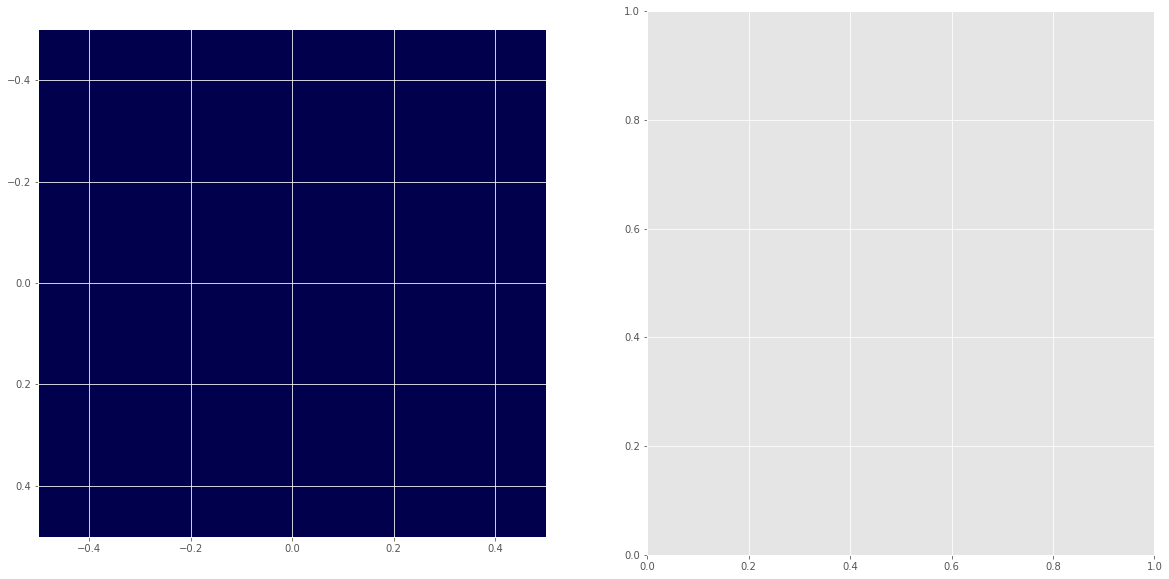

In [18]:
print(y.shape, y[1])

In [19]:

from keras.layers.pooling import MaxPooling3D, GlobalMaxPool3D
from keras.layers.convolutional import Conv2D, Conv3DTranspose, Conv3D
def conv2d_block(input_tensor, n_filters, kernel_size=3, batchnorm=True):
    # first layer
    x = Conv3D(filters=n_filters, kernel_size=(kernel_size, kernel_size,kernel_size), kernel_initializer="he_normal",
               padding="same")(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation("relu")(x)
    # second layer
    x = Conv3D(filters=n_filters, kernel_size=(kernel_size, kernel_size,kernel_size), kernel_initializer="he_normal",
               padding="same")(x)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation("relu")(x)
    return x

In [94]:
def get_unet(input_img, n_filters=16, dropout=0.5, batchnorm=True):
    # contracting path
    c1 = conv2d_block(input_img, n_filters=n_filters*1, kernel_size=3, batchnorm=batchnorm)
    p1 = MaxPooling3D((2, 2,2)) (c1)
    p1 = Dropout(dropout*0.5)(p1)

    c2 = conv2d_block(p1, n_filters=n_filters*2, kernel_size=3, batchnorm=batchnorm)
    p2 = MaxPooling3D((2, 2,2)) (c2)
    p2 = Dropout(dropout)(p2)

    c3 = conv2d_block(p2, n_filters=n_filters*4, kernel_size=3, batchnorm=batchnorm)
    p3 = MaxPooling3D((2, 2,2)) (c3)
    p3 = Dropout(dropout)(p3)

    c4 = conv2d_block(p3, n_filters=n_filters*8, kernel_size=3, batchnorm=batchnorm)
    p4 = MaxPooling3D(pool_size=(2, 2,2)) (c4)
    p4 = Dropout(dropout)(p4)
    
    #autoencoder.add(Flatten())
    #autoencoder.add(Reshape((1,12, 12,32 )))
    
    c5 = conv2d_block(p4, n_filters=n_filters*16, kernel_size=3, batchnorm=batchnorm)
    
    # expansive path
    u6 = Conv3DTranspose(n_filters*8, (3, 3,3), strides=(2,2,2), padding='same') (c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters=n_filters*8, kernel_size=3, batchnorm=batchnorm)

    u7 = Conv3DTranspose(n_filters*4, (3, 3,3), strides=(2, 2,2), padding='same') (c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters=n_filters*4, kernel_size=3, batchnorm=batchnorm)

    u8 = Conv3DTranspose(n_filters*2, (3, 3,3), strides=(2, 2,2), padding='same') (c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters=n_filters*2, kernel_size=3, batchnorm=batchnorm)

    u9 = Conv3DTranspose(n_filters*1, (3, 3,3), strides=(2, 2,2), padding='same',name='man1') (c8)
    u9 = concatenate([u9, c1])
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters=n_filters*1, kernel_size=3, batchnorm=batchnorm)
    
    outputs = Conv3D(1, (1, 1,1), activation='sigmoid') (c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

In [95]:
input_img = Input((128, 128, 128,1), name='img')
model = get_unet(input_img, n_filters=16, dropout=0.05, batchnorm=True)

model.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=["accuracy"])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                (None, 128, 128, 128 0                                            
__________________________________________________________________________________________________
conv3d_588 (Conv3D)             (None, 128, 128, 128 448         img[0][0]                        
__________________________________________________________________________________________________
batch_normalization_567 (BatchN (None, 128, 128, 128 64          conv3d_588[0][0]                 
__________________________________________________________________________________________________
activation_567 (Activation)     (None, 128, 128, 128 0           batch_normalization_567[0][0]    
__________________________________________________________________________________________________
conv3d_589

__________________________________________________________________________________________________
concatenate_9 (Concatenate)     (None, 16, 16, 16, 2 0           conv3d_transpose_67[0][0]        
                                                                 activation_574[0][0]             
__________________________________________________________________________________________________
dropout_254 (Dropout)           (None, 16, 16, 16, 2 0           concatenate_9[0][0]              
__________________________________________________________________________________________________
conv3d_598 (Conv3D)             (None, 16, 16, 16, 1 884864      dropout_254[0][0]                
__________________________________________________________________________________________________
batch_normalization_577 (BatchN (None, 16, 16, 16, 1 512         conv3d_598[0][0]                 
__________________________________________________________________________________________________
activation

In [98]:
callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=3, min_lr=0.00001, verbose=1),
    ModelCheckpoint('model-tgs-salt.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

In [99]:
results = model.fit(X_train, y_train, batch_size=2, epochs=2, callbacks=callbacks,
                    validation_data=(X_valid, y_valid),verbose=1)

ValueError: Error when checking input: expected img to have shape (128, 128, 128, 1) but got array with shape (128, 128, 1, 1)

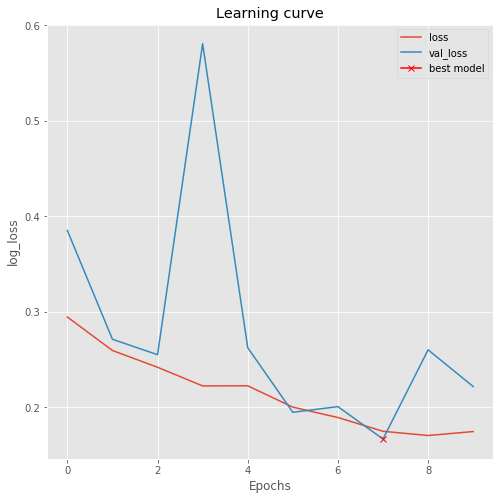

In [14]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(results.history["loss"], label="loss")
plt.plot(results.history["val_loss"], label="val_loss")
plt.plot( np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();

In [15]:
# Load best model
model.load_weights('model-tgs-salt.h5')

In [16]:
# Evaluate on validation set (this must be equals to the best log_loss)
model.evaluate(X_valid, y_valid, verbose=1)

600/600 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 2s 3ms/step


[0.166875637670358, 0.9316229240099589]

In [17]:
# Predict on train, val and test
preds_train = model.predict(X_train, verbose=1)
preds_val = model.predict(X_valid, verbose=1)

# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)

600/600 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 1s 2ms/step


In [18]:
def plot_sample(X, y, preds, binary_preds, ix=None):
    if ix is None:
        ix = random.randint(0, len(X))

    has_mask = y[ix].max() > 0

    fig, ax = plt.subplots(1, 4, figsize=(20, 10))
    ax[0].imshow(X[ix, ..., 0], cmap='seismic')
    if has_mask:
        ax[0].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[0].set_title('Seismic')

    ax[1].imshow(y[ix].squeeze())
    ax[1].set_title('Salt')

    ax[2].imshow(preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[2].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[2].set_title('Salt Predicted')
    
    ax[3].imshow(binary_preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[3].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[3].set_title('Salt Predicted binary');

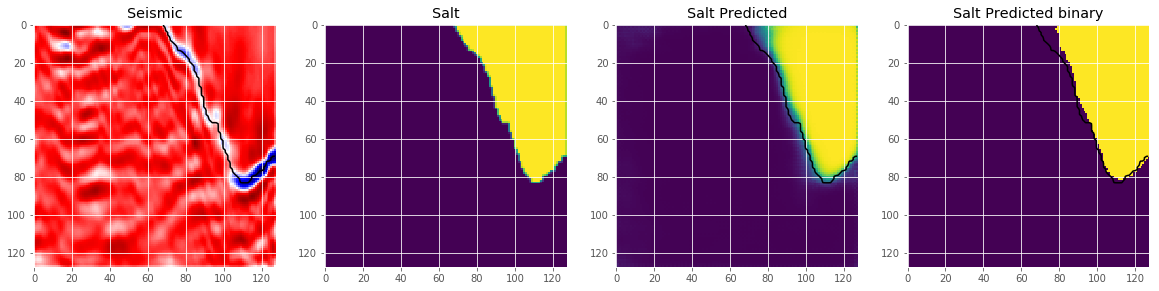

In [23]:
# Check if training data looks all right
plot_sample(X_train, y_train, preds_train, preds_train_t, ix=40)

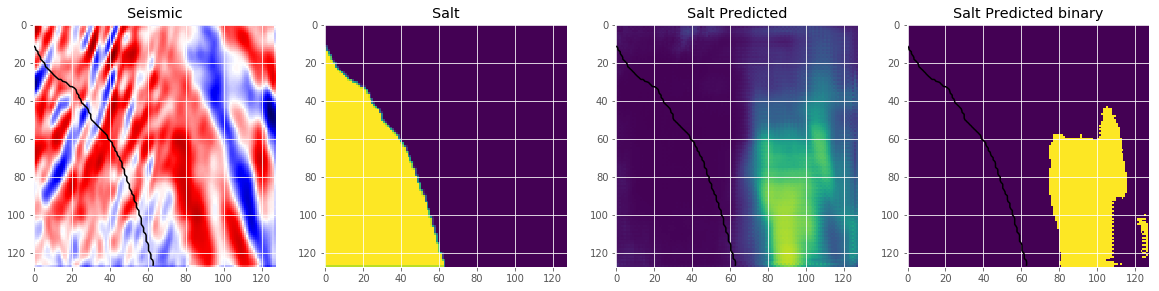

In [28]:
# Check if valid data looks all right
plot_sample(X_valid, y_valid, preds_val, preds_val_t, ix=90)